In [1]:
%matplotlib inline

import glob
import os
import pandas as pd
import numpy as np
import gffutils
import pysam
import pybedtools
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from collections import OrderedDict
from tqdm import tnrange, tqdm_notebook

pd.set_option('display.max_columns', 50)

In [2]:
input_dir = '/home/bay001/projects/kris_apobec_20200121/permanent_data/lenti_common_mapping/featurecounts/'
output_dir = '/home/bay001/projects/kris_apobec_20200121/permanent_data/lenti_common_mapping/featurecounts/'

In [3]:
def counts_to_rpkm(feature_counts_table):
    counts = feature_counts_table.ix[:,5:]
    lengths = feature_counts_table['Length']
    mapped_reads = counts.sum()
    return (counts * pow(10,9)).div(mapped_reads, axis=1).div(lengths, axis=0)

def counts_to_tpm(counts_table, skip_col=5):
    """
    simple function that converts a featureCounts pandas Dataframe
    into a TPM dataframe.
    
    :param counts_table: pandas.DataFrame() 
        either a featureCounts table (first five cols contain non-count info,
        the rest contain raw counts) or a generic counts table (use skip_col=0
        in this case)
    :return tpm: pandas.DataFrame
    """
    rpkm = counts_to_rpkm(counts_table)
    tpm = rpkm.div(rpkm.sum())*pow(10,6)
    return tpm

In [4]:
# counts_file = os.path.join(input_dir, 'counts.three_prime_utr_lenti_common2kb.txt')
counts_file = os.path.join(input_dir, 'counts.exons_no3utr.txt')
counts_table = pd.read_csv(counts_file, index_col=0, skiprows=1, sep='\t')
tpm = counts_to_tpm(counts_table)
tpm.head()

/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


,../outputs/ABCE1-0_S1_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/ABCE1-1000_S15_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/ABCE1-50_S8_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/APOBEC_only_0_72hr_S32_combined_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/APOBEC_only_0_merged_R1.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/APOBEC_only_1000_72hr_S34_combined_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/APOBEC_only_1000_merged_R1.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/APOBEC_only_50_72hr_S33_combined_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/APOBEC_only_50_merged_R1.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/Apobec_plusT_1_S30_L003_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/Apobec_plusT_2_S31_L003_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/Apobec-T_1_S28_L003_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/Apobec-T_2_S29_L003_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/ApoControl-0_S7_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/ApoControl-1000_S21_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/ApoControl-50_S14_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/ETF1-0_S2_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/ETF1-1000_S16_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/ETF1-50_S9_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/GSTP1-0_S3_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/GSTP1-1000_S17_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/GSTP1-50_S10_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/RBFOX_0_48hr_S17_combined_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/RBFOX_0_72hr_S20_combined_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/RBFOX_1000_48hr_S19_combined_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,...,../outputs/RPS2-0_S4_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/RPS2-1000_S18_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/RPS2-50_S11_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/RPS2_plusT_1_S38_L003_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/RPS2_plusT_2_S39_L003_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/RPS2-T_1_S36_L003_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/RPS2-T_2_S37_L003_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/RPS3-0_S5_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/RPS3-1000_S19_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/RPS3-50_S12_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/SLBP_0_48hr_A_S29_combined_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/SLBP_0_48hr_B_S30_combined_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/SLBP_0_48hr_C_S31_combined_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.s

In [5]:
counts_table.head()

,Chr,Start,End,Strand,Length,../outputs/ABCE1-0_S1_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/ABCE1-1000_S15_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/ABCE1-50_S8_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/APOBEC_only_0_72hr_S32_combined_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/APOBEC_only_0_merged_R1.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/APOBEC_only_1000_72hr_S34_combined_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/APOBEC_only_1000_merged_R1.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/APOBEC_only_50_72hr_S33_combined_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/APOBEC_only_50_merged_R1.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/Apobec_plusT_1_S30_L003_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/Apobec_plusT_2_S31_L003_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/Apobec-T_1_S28_L003_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/Apobec-T_2_S29_L003_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/ApoControl-0_S7_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/ApoControl-1000_S21_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/ApoControl-50_S14_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/ETF1-0_S2_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/ETF1-1000_S16_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/ETF1-50_S9_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/GSTP1-0_S3_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,...,../outputs/RPS2-0_S4_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/RPS2-1000_S18_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/RPS2-50_S11_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/RPS2_plusT_1_S38_L003_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/RPS2_plusT_2_S39_L003_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/RPS2-T_1_S36_L003_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/RPS2-T_2_S37_L003_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/RPS3-0_S5_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/RPS3-1000_S19_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/RPS3-50_S12_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/SLBP_0_48hr_A_S29_combined_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/SLBP_0_48hr_B_S30_combined_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/SLBP_0_48hr_C_S31_combined_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/SLBP_0_72hr_A_S23_combined_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/SLBP_0_72hr_B_S24_combined_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/SLBP_0_72hr_C_S25_combined_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/SLBP_1000_72hr_A_S26_combined_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../outputs/SLBP_1000_72hr_B_S27_combined_R1_001.fastqT

In [6]:
# for col in pd.DataFrame(counts_table.loc['lenti_common']).index:
#     print(col, counts_table[[col]].loc['lenti_common'][0])

In [7]:
tpm.columns = [c.replace('../outputs/','').replace('.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam','') for c in tpm.columns]
tpm.head()

,ABCE1-0_S1_L001_R1_001,ABCE1-1000_S15_L002_R1_001,ABCE1-50_S8_L001_R1_001,APOBEC_only_0_72hr_S32_combined_R1_001,APOBEC_only_0_merged_R1,APOBEC_only_1000_72hr_S34_combined_R1_001,APOBEC_only_1000_merged_R1,APOBEC_only_50_72hr_S33_combined_R1_001,APOBEC_only_50_merged_R1,Apobec_plusT_1_S30_L003_R1_001,Apobec_plusT_2_S31_L003_R1_001,Apobec-T_1_S28_L003_R1_001,Apobec-T_2_S29_L003_R1_001,ApoControl-0_S7_L001_R1_001,ApoControl-1000_S21_L002_R1_001,ApoControl-50_S14_L002_R1_001,ETF1-0_S2_L001_R1_001,ETF1-1000_S16_L002_R1_001,ETF1-50_S9_L001_R1_001,GSTP1-0_S3_L001_R1_001,GSTP1-1000_S17_L002_R1_001,GSTP1-50_S10_L001_R1_001,RBFOX_0_48hr_S17_combined_R1_001,RBFOX_0_72hr_S20_combined_R1_001,RBFOX_1000_48hr_S19_combined_R1_001,...,RPS2-0_S4_L001_R1_001,RPS2-1000_S18_L002_R1_001,RPS2-50_S11_L001_R1_001,RPS2_plusT_1_S38_L003_R1_001,RPS2_plusT_2_S39_L003_R1_001,RPS2-T_1_S36_L003_R1_001,RPS2-T_2_S37_L003_R1_001,RPS3-0_S5_L001_R1_001,RPS3-1000_S19_L002_R1_001,RPS3-50_S12_L001_R1_001,SLBP_0_48hr_A_S29_combined_R1_001,SLBP_0_48hr_B_S30_combined_R1_001,SLBP_0_48hr_C_S31_combined_R1_001,SLBP_0_72hr_A_S23_combined_R1_001,SLBP_0_72hr_B_S24_combined_R1_001,SLBP_0_72hr_C_S25_combined_R1_001,SLBP_1000_72hr_A_S26_combined_R1_001,SLBP_1000_72hr_B_S27_combined_R1_001,SLBP_1000_72hr_C_S28_combined_R1_001,Tia1_0ng_1_S40_L003_R1_001,Tia1_0ng_2_S41_L003_R1_001,Tia1_1000ng_1_S14_L001_R1_001,Tia1_1000ng_2_S27_L002_R1_001,Tia1_50ng_1_S42_L003_R1_001,Tia1_50ng_2_S13_L001_R1_001
Geneid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ENSG00000237683,0.000000,0.083678,0.000000,0.000000,0.000000,0.000000,0.000000,0.170188,0.177402,0.000000,0.161997,0.000000,0.000000,0.000000,0.000000,0.268829,0.463545,0.000000,0.000000,0.000000,0.141493,0.140185,0.130361,0.000000,0.000000,...,0.092489,0.000000,0.000000,0.000000,0.154493,0.000000,0.130687,0.362040,0.059666,0.0,0.000000,0.000000,0.282586,0.000000,0.000000,0.302873,0.000000,0.358616,0.144832,0.000000,0.000000,0.000000,0.500036,0.000000,0.000000
ENSG00000235249,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000185097,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000187634,11.587928,13.634595,10.269166,30.616448,32.172858,20.761378,21.533112,22.974884,23.948766,25.134232,44.972879,0.623626,10.127226,25.739697,18.012190,21.332441,29.942946,5.804719,12.628437,12.434258,24.158958,21.137546,36.663273,24.296960,22.139846,...,37.524541,6.081895,28.486489,133.342774,126.538708,40.127246,82.521130,22.965752,21.457523,0.0,22.097159,24.114362,18.766546,36.552790,44.987076,29.950923,35.825808,35.528290,32.691782,1.298489,9.414428,36.562528,30.425001,19.825869,25.829971
ENSG00000188976,82.455270,113.610779,91.654227,98.729185,102.909252,88.229734,91.000769,87.229835,90.404093,78.577518,126.339597,11.454820,92.472873,111.772964,101.259931,114.129760,181.098701,62.464976,105.967328,100.266854,155.010486,134.295835,120.317899,98.542778,92.387204,...,192.179635,61.123504,143.575151,130.490122,155.522899,142.692265,199.072363,125.435975,111.765949,0.0,89.238779,88.186579,74.573394,92.281487,122.731586,130.947260,121.134828,121.833943,122.245773,22.649790,70.329358,145.990686,145.356221,109.713212,120.951693


In [8]:
def gene_id_to_name(db):
    """
    Returns a dictionary containing a gene_id:name translation
    Note: may be different if the 'gene_id' or 'gene_name' 
    keys are not in the source GTF file
    (taken from gscripts.region_helpers)
    """
    genes = db.features_of_type('gene')
    gene_name_dict = {}
    for gene in genes:
        gene_id = gene.attributes['gene_id'][0] if type(gene.attributes['gene_id']) == list else gene.attributes['gene_id']
        try:
            gene_name_dict[gene_id.split('.')[0]] = gene.attributes['gene_name'][0]  # this is for ENSEMBL-style IDs! 
        except KeyError:
            print(gene.attributes.keys())
            print("Warning. Key not found for {}".format(gene))
            return 1
    return gene_name_dict


db_file = '/projects/ps-yeolab4/genomes/hg19/gencode_v19/gencode.v19.annotation.gtf.db'
DATABASE = gffutils.FeatureDB(db_file)
gene_id_to_name_dictionary = gene_id_to_name(DATABASE)
# gene_id_to_name_dictionary['ENSG00000100320.18']
gene_id_to_name_dictionary['ENSG00000100320']

/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/gffutils/interface.py:161: UserWarning: It appears that this database has not had the ANALYZE sqlite3 command run on it. Doing so can dramatically speed up queries, and is done by default for databases created with gffutils >0.8.7.1 (this database was created with version 0.8.1) Consider calling the analyze() method of this object.
  "method of this object." % self.version)


'RBFOX2'

In [9]:
def geneid2name(row, d=gene_id_to_name_dictionary):
    try:
        return d[row['Geneid']]
    except KeyError:
        return row['Geneid']

tpm.reset_index(inplace=True)
tpm['Genename'] = tpm.apply(geneid2name, axis=1)
tpm.head()

,Geneid,ABCE1-0_S1_L001_R1_001,ABCE1-1000_S15_L002_R1_001,ABCE1-50_S8_L001_R1_001,APOBEC_only_0_72hr_S32_combined_R1_001,APOBEC_only_0_merged_R1,APOBEC_only_1000_72hr_S34_combined_R1_001,APOBEC_only_1000_merged_R1,APOBEC_only_50_72hr_S33_combined_R1_001,APOBEC_only_50_merged_R1,Apobec_plusT_1_S30_L003_R1_001,Apobec_plusT_2_S31_L003_R1_001,Apobec-T_1_S28_L003_R1_001,Apobec-T_2_S29_L003_R1_001,ApoControl-0_S7_L001_R1_001,ApoControl-1000_S21_L002_R1_001,ApoControl-50_S14_L002_R1_001,ETF1-0_S2_L001_R1_001,ETF1-1000_S16_L002_R1_001,ETF1-50_S9_L001_R1_001,GSTP1-0_S3_L001_R1_001,GSTP1-1000_S17_L002_R1_001,GSTP1-50_S10_L001_R1_001,RBFOX_0_48hr_S17_combined_R1_001,RBFOX_0_72hr_S20_combined_R1_001,...,RPS2-1000_S18_L002_R1_001,RPS2-50_S11_L001_R1_001,RPS2_plusT_1_S38_L003_R1_001,RPS2_plusT_2_S39_L003_R1_001,RPS2-T_1_S36_L003_R1_001,RPS2-T_2_S37_L003_R1_001,RPS3-0_S5_L001_R1_001,RPS3-1000_S19_L002_R1_001,RPS3-50_S12_L001_R1_001,SLBP_0_48hr_A_S29_combined_R1_001,SLBP_0_48hr_B_S30_combined_R1_001,SLBP_0_48hr_C_S31_combined_R1_001,SLBP_0_72hr_A_S23_combined_R1_001,SLBP_0_72hr_B_S24_combined_R1_001,SLBP_0_72hr_C_S25_combined_R1_001,SLBP_1000_72hr_A_S26_combined_R1_001,SLBP_1000_72hr_B_S27_combined_R1_001,SLBP_1000_72hr_C_S28_combined_R1_001,Tia1_0ng_1_S40_L003_R1_001,Tia1_0ng_2_S41_L003_R1_001,Tia1_1000ng_1_S14_L001_R1_001,Tia1_1000ng_2_S27_L002_R1_001,Tia1_50ng_1_S42_L003_R1_001,Tia1_50ng_2_S13_L001_R1_001,Genename
0,ENSG00000237683,0.000000,0.083678,0.000000,0.000000,0.000000,0.000000,0.000000,0.170188,0.177402,0.000000,0.161997,0.000000,0.000000,0.000000,0.000000,0.268829,0.463545,0.000000,0.000000,0.000000,0.141493,0.140185,0.130361,0.000000,...,0.000000,0.000000,0.000000,0.154493,0.000000,0.130687,0.362040,0.059666,0.0,0.000000,0.000000,0.282586,0.000000,0.000000,0.302873,0.000000,0.358616,0.144832,0.000000,0.000000,0.000000,0.500036,0.000000,0.000000,AL627309.1
1,ENSG00000235249,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,OR4F29
2,ENSG00000185097,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,OR4F16
3,ENSG00000187634,11.587928,13.634595,10.269166,30.616448,32.172858,20.761378,21.533112,22.974884,23.948766,25.134232,44.972879,0.623626,10.127226,25.739697,18.012190,21.332441,29.942946,5.804719,12.628437,12.434258,24.158958,21.137546,36.663273,24.296960,...,6.081895,28.486489,133.342774,126.538708,40.127246,82.521130,22.965752,21.457523,0.0,22.097159,24.114362,18.766546,36.552790,44.987076,29.950923,35.825808,35.528290,32.691782,1.298489,9.414428,36.562528,30.425001,19.825869,25.829971,SAMD11
4,ENSG00000188976,82.455270,113.610779,91.654227,98.729185,102.909252,88.229734,91.000769,87.229835,90.404093,78.577518,126.339597,11.454820,92.472873,111.772964,101.259931,114.129760,181.098701,62.464976,105.967328,100.266854,155.010486,134.295835,120.317899,98.542778,...,61.123504,143.575151,130.490122,155.522899,142.692265,199.072363,125.435975,111.765949,0.0,89.238779,88.186579,74.573394,92.281487,122.731586,130.947260,121.134828,121.833943,122.245773,22.649790,70.329358,145.990686,145.356221,109.713212,120.951693,NOC2L


In [10]:
tpm.set_index("Genename", inplace=True)
# goi = ['lenti_common']
goi = ['RBFOX2']

In [11]:
del tpm['Geneid']
tpm.loc[goi]

,ABCE1-0_S1_L001_R1_001,ABCE1-1000_S15_L002_R1_001,ABCE1-50_S8_L001_R1_001,APOBEC_only_0_72hr_S32_combined_R1_001,APOBEC_only_0_merged_R1,APOBEC_only_1000_72hr_S34_combined_R1_001,APOBEC_only_1000_merged_R1,APOBEC_only_50_72hr_S33_combined_R1_001,APOBEC_only_50_merged_R1,Apobec_plusT_1_S30_L003_R1_001,Apobec_plusT_2_S31_L003_R1_001,Apobec-T_1_S28_L003_R1_001,Apobec-T_2_S29_L003_R1_001,ApoControl-0_S7_L001_R1_001,ApoControl-1000_S21_L002_R1_001,ApoControl-50_S14_L002_R1_001,ETF1-0_S2_L001_R1_001,ETF1-1000_S16_L002_R1_001,ETF1-50_S9_L001_R1_001,GSTP1-0_S3_L001_R1_001,GSTP1-1000_S17_L002_R1_001,GSTP1-50_S10_L001_R1_001,RBFOX_0_48hr_S17_combined_R1_001,RBFOX_0_72hr_S20_combined_R1_001,RBFOX_1000_48hr_S19_combined_R1_001,...,RPS2-0_S4_L001_R1_001,RPS2-1000_S18_L002_R1_001,RPS2-50_S11_L001_R1_001,RPS2_plusT_1_S38_L003_R1_001,RPS2_plusT_2_S39_L003_R1_001,RPS2-T_1_S36_L003_R1_001,RPS2-T_2_S37_L003_R1_001,RPS3-0_S5_L001_R1_001,RPS3-1000_S19_L002_R1_001,RPS3-50_S12_L001_R1_001,SLBP_0_48hr_A_S29_combined_R1_001,SLBP_0_48hr_B_S30_combined_R1_001,SLBP_0_48hr_C_S31_combined_R1_001,SLBP_0_72hr_A_S23_combined_R1_001,SLBP_0_72hr_B_S24_combined_R1_001,SLBP_0_72hr_C_S25_combined_R1_001,SLBP_1000_72hr_A_S26_combined_R1_001,SLBP_1000_72hr_B_S27_combined_R1_001,SLBP_1000_72hr_C_S28_combined_R1_001,Tia1_0ng_1_S40_L003_R1_001,Tia1_0ng_2_S41_L003_R1_001,Tia1_1000ng_1_S14_L001_R1_001,Tia1_1000ng_2_S27_L002_R1_001,Tia1_50ng_1_S42_L003_R1_001,Tia1_50ng_2_S13_L001_R1_001
Genename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
RBFOX2,27.37954,35.974736,28.673882,57.729752,60.537601,53.012325,54.826677,47.913119,49.944106,9.441466,50.999493,13.783542,43.749512,35.174283,34.857309,33.601237,38.80681,29.84444,31.33947,27.608315,36.288253,31.455064,69.323422,69.617691,654.905837,...,33.308637,29.680525,37.94622,29.575375,44.176195,25.435719,38.417299,40.886396,37.543592,0.0,56.326128,53.851637,52.660105,64.104005,72.936701,69.720828,65.397428,60.596064,66.854472,49.076252,58.878575,57.136907,52.607092,49.365777,56.414176


In [12]:
l2tpm = np.log2(tpm+1)
l2tpm.loc[goi]

,ABCE1-0_S1_L001_R1_001,ABCE1-1000_S15_L002_R1_001,ABCE1-50_S8_L001_R1_001,APOBEC_only_0_72hr_S32_combined_R1_001,APOBEC_only_0_merged_R1,APOBEC_only_1000_72hr_S34_combined_R1_001,APOBEC_only_1000_merged_R1,APOBEC_only_50_72hr_S33_combined_R1_001,APOBEC_only_50_merged_R1,Apobec_plusT_1_S30_L003_R1_001,Apobec_plusT_2_S31_L003_R1_001,Apobec-T_1_S28_L003_R1_001,Apobec-T_2_S29_L003_R1_001,ApoControl-0_S7_L001_R1_001,ApoControl-1000_S21_L002_R1_001,ApoControl-50_S14_L002_R1_001,ETF1-0_S2_L001_R1_001,ETF1-1000_S16_L002_R1_001,ETF1-50_S9_L001_R1_001,GSTP1-0_S3_L001_R1_001,GSTP1-1000_S17_L002_R1_001,GSTP1-50_S10_L001_R1_001,RBFOX_0_48hr_S17_combined_R1_001,RBFOX_0_72hr_S20_combined_R1_001,RBFOX_1000_48hr_S19_combined_R1_001,...,RPS2-0_S4_L001_R1_001,RPS2-1000_S18_L002_R1_001,RPS2-50_S11_L001_R1_001,RPS2_plusT_1_S38_L003_R1_001,RPS2_plusT_2_S39_L003_R1_001,RPS2-T_1_S36_L003_R1_001,RPS2-T_2_S37_L003_R1_001,RPS3-0_S5_L001_R1_001,RPS3-1000_S19_L002_R1_001,RPS3-50_S12_L001_R1_001,SLBP_0_48hr_A_S29_combined_R1_001,SLBP_0_48hr_B_S30_combined_R1_001,SLBP_0_48hr_C_S31_combined_R1_001,SLBP_0_72hr_A_S23_combined_R1_001,SLBP_0_72hr_B_S24_combined_R1_001,SLBP_0_72hr_C_S25_combined_R1_001,SLBP_1000_72hr_A_S26_combined_R1_001,SLBP_1000_72hr_B_S27_combined_R1_001,SLBP_1000_72hr_C_S28_combined_R1_001,Tia1_0ng_1_S40_L003_R1_001,Tia1_0ng_2_S41_L003_R1_001,Tia1_1000ng_1_S14_L001_R1_001,Tia1_1000ng_2_S27_L002_R1_001,Tia1_50ng_1_S42_L003_R1_001,Tia1_50ng_2_S13_L001_R1_001
Genename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
RBFOX2,4.826779,5.208468,4.891122,5.87602,5.943396,5.755217,5.802883,5.61215,5.670843,3.384252,5.700426,3.88592,5.4838,5.176893,5.164195,5.112752,5.314943,4.946939,5.015224,4.838363,5.220649,5.020372,6.135933,6.141958,9.357345,...,5.1005,4.939251,5.283411,4.934298,5.497491,4.724417,5.300757,5.38841,5.268419,0.0,5.841121,5.777463,5.745778,6.024674,6.208219,6.144063,6.053055,5.944766,6.084372,5.646055,5.903968,5.861382,5.744352,5.654372,5.843335


In [13]:
l2tpm.loc[goi].columns

Index(['ABCE1-0_S1_L001_R1_001', 'ABCE1-1000_S15_L002_R1_001',
       'ABCE1-50_S8_L001_R1_001', 'APOBEC_only_0_72hr_S32_combined_R1_001',
       'APOBEC_only_0_merged_R1', 'APOBEC_only_1000_72hr_S34_combined_R1_001',
       'APOBEC_only_1000_merged_R1', 'APOBEC_only_50_72hr_S33_combined_R1_001',
       'APOBEC_only_50_merged_R1', 'Apobec_plusT_1_S30_L003_R1_001',
       'Apobec_plusT_2_S31_L003_R1_001', 'Apobec-T_1_S28_L003_R1_001',
       'Apobec-T_2_S29_L003_R1_001', 'ApoControl-0_S7_L001_R1_001',
       'ApoControl-1000_S21_L002_R1_001', 'ApoControl-50_S14_L002_R1_001',
       'ETF1-0_S2_L001_R1_001', 'ETF1-1000_S16_L002_R1_001',
       'ETF1-50_S9_L001_R1_001', 'GSTP1-0_S3_L001_R1_001',
       'GSTP1-1000_S17_L002_R1_001', 'GSTP1-50_S10_L001_R1_001',
       'RBFOX_0_48hr_S17_combined_R1_001', 'RBFOX_0_72hr_S20_combined_R1_001',
       'RBFOX_1000_48hr_S19_combined_R1_001',
       'RBFOX_1000_72hr_S22_combined_R1_001', 'RBFOX2-0_S6_L001_R1_001',
       'RBFOX2-1000_S20_L002_R1_001'

In [14]:
rbpoi = [
    'ApoControl-0_S7_L001_R1_001',
    'ApoControl-50_S14_L002_R1_001',
    'ApoControl-1000_S21_L002_R1_001',
    'RBFOX2-0_S6_L001_R1_001',
    'RBFOX2-50_S13_L002_R1_001',
    'RBFOX2-1000_S20_L002_R1_001',
]

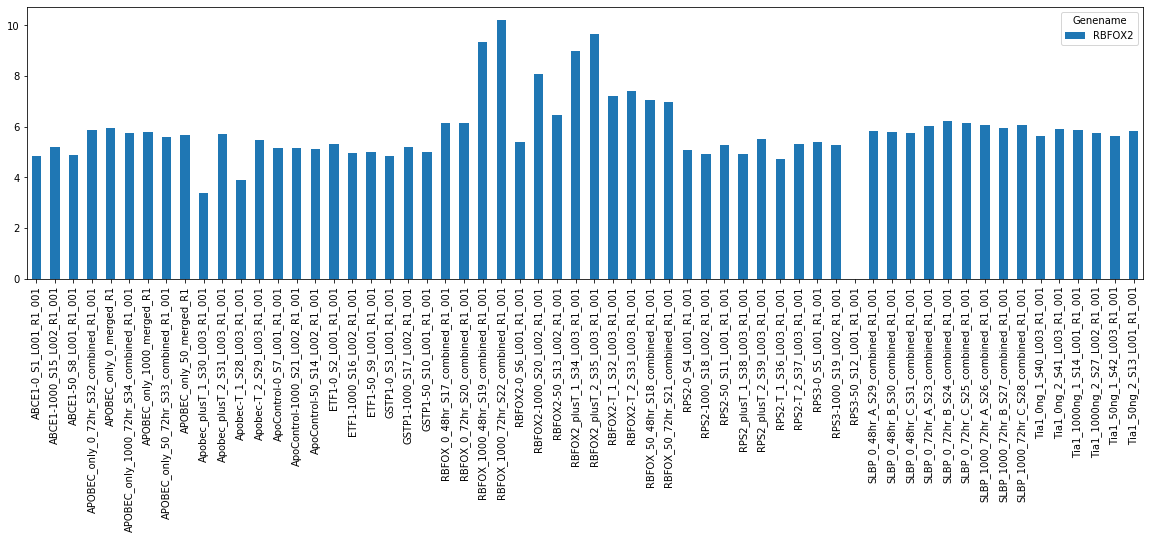

In [15]:
fig, ax = plt.subplots(figsize=(20, 5))
l2tpm.loc[goi].T.plot(kind='bar', ax=ax)

/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.


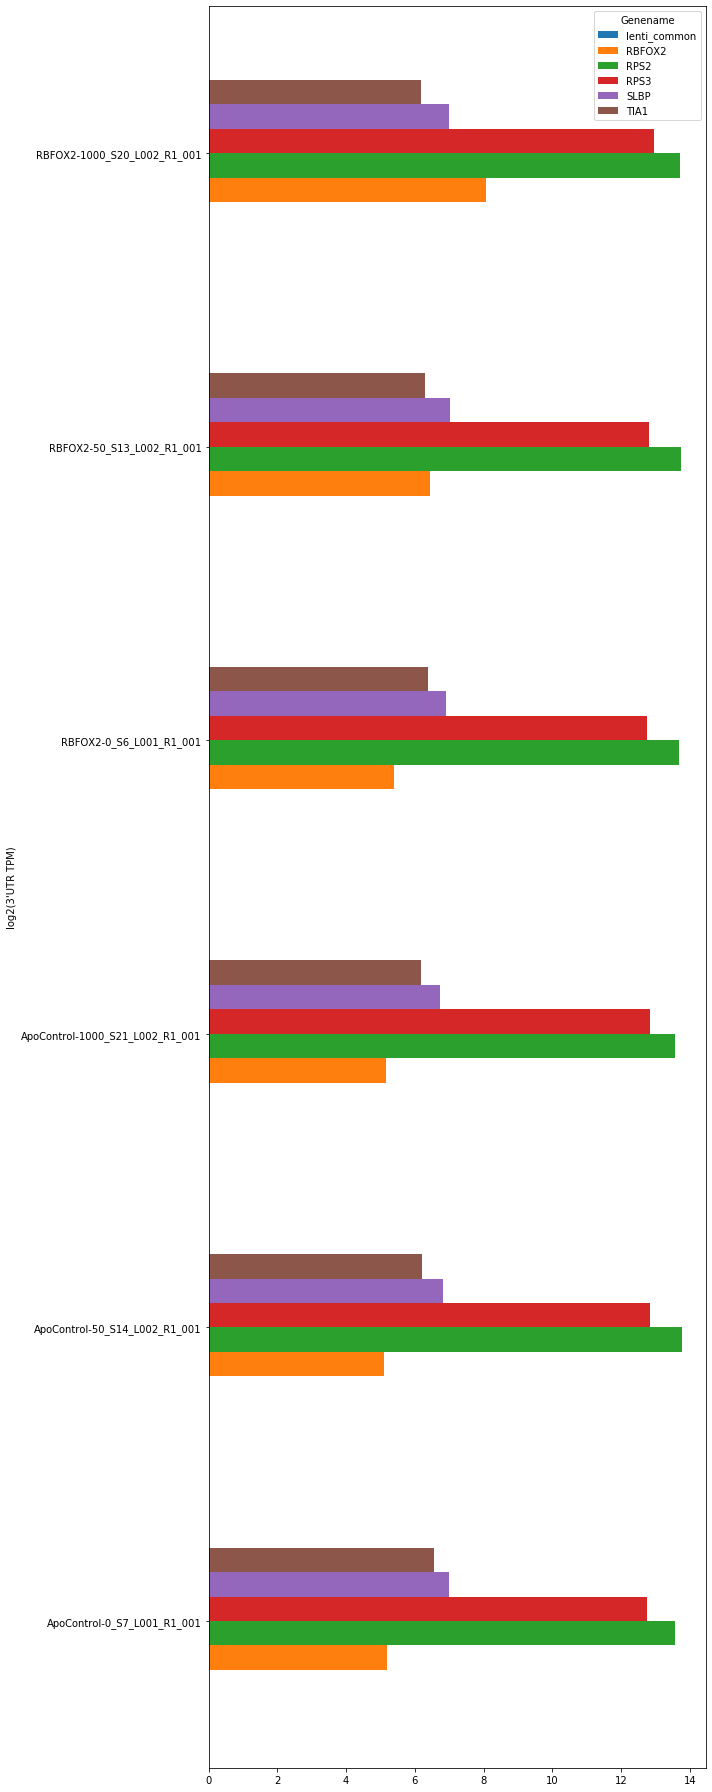

In [16]:
goi = ['lenti_common', 'RBFOX2', 'RPS2', 'RPS3', 'SLBP', 'TIA1']

fig, ax = plt.subplots(figsize=(10, 25))
l2tpm.loc[goi][rbpoi].T.plot(kind='barh', ax=ax)
ax.set_ylabel("log2(3\'UTR TPM)")
plt.tight_layout()
fig.savefig(os.path.join(output_dir, 'l2tpm-no3utr-expression.svg'))
fig.savefig(os.path.join(output_dir, 'l2tpm-no3utr-expression.png'))

In [17]:
l2tpm.loc[goi][rbpoi].T.to_csv(os.path.join(output_dir, 'l2tpm-no3utr-expression.tsv'), sep='\t', index=True, header=True)

/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
